# mid-cap crypto momentum strategy

In [ ]:
import pandas as pd
import numpy as np
from binance.client import Client as BinanceClient
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
from binance.client import Client as client
from skopt import gp_minimize
from skopt.space import Integer, Real

**🦩 For learning purposes** 

In [79]:
# Download OHLCV data for a given symbol from Binance.
def fetch_binance_prices(symbol, interval, start_date='2015-01-01', end_date='2024-10-01'):
    
    raw = client.get_historical_klines(symbol, interval, start_date, end_date)
    
    col_names = [
        'open_time','open','high','low','close','volume',
        'close_time','quote_volume','num_trades',
        'taker_base_volume','taker_quote_volume','ignore'
    ]
    
    df = pd.DataFrame(raw, columns=col_names)

    # Convert timestamps
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms', utc=True)

    return df

In [80]:
client = BinanceClient(tld='com')
binance_symbols = [info['symbol'] for info in client.get_exchange_info()['symbols']]


Select USDT pairs where the underlying asset has mid-cap market cap & liquidity.

In [81]:
def get_midcap_universe(universe, cap_low=5e8, cap_high=5e9, vol_threshold=5e6):
    
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {"vs_currency":"usd","order":"market_cap_desc","per_page":250,"page":1}
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    market_data = response.json()

    # Map symbol to cap & volume
    fundamentals = {
        coin['symbol'].upper() + "USDT": {
            "cap": coin['market_cap'],
            "volume": coin['total_volume']
        }
        for coin in market_data
    }

    # Keep only midcap coins
    filtered = [
        token for token in universe
        if token in fundamentals
        and cap_low <= fundamentals[token]["cap"] <= cap_high
        and fundamentals[token]["volume"] >= vol_threshold
    ]
    return filtered

# Example usage
midcap_symbols = get_midcap_universe(binance_symbols)
print("Filtered midcap universe:", midcap_symbols)
print(f"{len(midcap_symbols)} midcap pairs")

Filtered midcap universe: ['IOTAUSDT', 'ETCUSDT', 'VETUSDT', 'USDCUSDT', 'BTTUSDT', 'FETUSDT', 'ZECUSDT', 'THETAUSDT', 'ATOMUSDT', 'ALGOUSDT', 'XTZUSDT', 'STXUSDT', 'MANAUSDT', 'CRVUSDT', 'SANDUSDT', 'PAXGUSDT', 'SUNUSDT', 'AAVEUSDT', 'NEARUSDT', 'FILUSDT', 'INJUSDT', 'GRTUSDT', 'TWTUSDT', 'CAKEUSDT', 'CFXUSDT', 'ICPUSDT', 'DEXEUSDT', 'QNTUSDT', 'FLOWUSDT', 'RAYUSDT', 'DYDXUSDT', 'GALAUSDT', 'ENSUSDT', 'JASMYUSDT', 'IMXUSDT', 'NEXOUSDT', 'LDOUSDT', 'OPUSDT', 'APTUSDT', 'ARBUSDT', 'WBTCUSDT', 'PEPEUSDT', 'FLOKIUSDT', 'PENDLEUSDT', 'WLDUSDT', 'FDUSDUSDT', 'SEIUSDT', 'TIAUSDT', 'JTOUSDT', 'BONKUSDT', 'JUPUSDT', 'PYTHUSDT', 'STRKUSDT', 'WIFUSDT', 'ETHFIUSDT', 'ENAUSDT', 'WUSDT', 'TAOUSDT', 'RENDERUSDT', 'POLUSDT', 'EIGENUSDT', 'BNSOLUSDT', 'KAIAUSDT', 'PENGUUSDT', 'SUSDT', 'TRUMPUSDT', 'FORMUSDT', 'ONDOUSDT', 'VIRTUALUSDT', 'USD1USDT', 'AUSDT', 'BFUSDUSDT', 'PUMPUSDT', 'SKYUSDT']
74 midcap pairs


Pull daily close prices for a universe of Binance symbols, combine into DataFrame, and compute returns.

In [57]:
import pandas as pd

# helper to map Binance intervals -> pandas frequency
_PD_FREQ = {
    '1m':'T','3m':'3T','5m':'5T','15m':'15T','30m':'30T',
    '1h':'H','2h':'2H','4h':'4H','6h':'6H','8h':'8H','12h':'12H',
    '1d':'D','3d':'3D','1w':'W','1M':'MS'
}
def _pd_freq(interval: str) -> str:
    return _PD_FREQ.get(interval, 'D')

def _fetch_close_series(symbol: str, interval: str):

    df = fetch_binance_prices(symbol, interval)
    if df is None or df.empty:
        return None

    # Ensure required columns exist and are usable
    if 'open_time' not in df or 'close' not in df:
        return None

    s = pd.to_numeric(df['close'], errors='coerce')
    idx = pd.to_datetime(df['open_time'], utc=True)
    s.index = idx
    s = s.dropna()

    # If still empty, treat as unusable
    if s.empty:
        return None

    return s.rename(symbol).sort_index()

# build panel, drop symbols with no data, compute returns (no forward fill)
def build_crypto_panel_clean(universe, interval='1d', min_rows=1, verbose=True):
    kept_series = []
    kept_syms = []
    dropped_syms = []

    for sym in universe:
        try:
            s = _fetch_close_series(sym, interval)
            if s is None or len(s) < min_rows:
                dropped_syms.append(sym)
            else:
                kept_series.append(s)
                kept_syms.append(sym)
        except Exception:
            # Any fetch/parse errors -> drop
            dropped_syms.append(sym)

    if not kept_series:
        raise ValueError("No valid symbols with data. All were filtered out.")

    prices = pd.concat(kept_series, axis=1)

    # Reindex to a continuous calendar for the chosen interval
    tz = prices.index.tz
    pd_freq = _pd_freq(interval)
    full_idx = pd.date_range(prices.index.min(), prices.index.max(), freq=pd_freq, tz=tz)
    prices = prices.reindex(full_idx)
    returns = prices.pct_change(fill_method=None)

    if verbose:
        print(f"Kept {len(kept_syms)} symbols, dropped {len(dropped_syms)} with no data.")
        if dropped_syms:
            print("Dropped (no data):", dropped_syms[:20], "..." if len(dropped_syms) > 20 else "")

    return prices, returns, kept_syms, dropped_syms

prices, returns, kept, dropped = build_crypto_panel_clean(midcap_symbols, interval='1d')

prices.to_csv("crypto_prices_daily.csv", index_label="date")
returns.to_csv("crypto_returns_daily.csv", index_label="date")

print(f"Saved daily prices and returns for {len(kept)} cryptos.")
returns.tail()


Kept 60 symbols, dropped 14 with no data.
Dropped (no data): ['EIGENUSDT', 'BNSOLUSDT', 'KAIAUSDT', 'PENGUUSDT', 'SUSDT', 'TRUMPUSDT', 'FORMUSDT', 'ONDOUSDT', 'VIRTUALUSDT', 'USD1USDT', 'AUSDT', 'BFUSDUSDT', 'PUMPUSDT', 'SKYUSDT'] 
Saved daily prices and returns for 60 cryptos.


,IOTAUSDT,ETCUSDT,VETUSDT,USDCUSDT,BTTUSDT,FETUSDT,ZECUSDT,THETAUSDT,ATOMUSDT,ALGOUSDT,...,JUPUSDT,PYTHUSDT,STRKUSDT,WIFUSDT,ETHFIUSDT,ENAUSDT,WUSDT,TAOUSDT,RENDERUSDT,POLUSDT
2024-09-27 00:00:00+00:00,0.017053,0.025603,0.043103,0.0000,NaN,0.030675,0.006283,-0.000658,0.026563,0.002784,...,0.002671,-0.000541,0.025327,0.024876,0.047221,-0.012088,0.105102,0.042743,0.059839,0.018558
2024-09-28 00:00:00+00:00,-0.040241,-0.013442,-0.030804,0.0000,NaN,-0.047024,-0.030562,-0.039500,-0.024125,-0.019431,...,-0.020780,-0.030582,-0.045904,0.045896,-0.038242,0.026140,-0.075716,-0.023866,-0.023749,-0.022140
2024-09-29 00:00:00+00:00,-0.000699,-0.005839,-0.001550,0.0000,NaN,0.012492,-0.014237,0.011652,0.001994,-0.001415,...,-0.001306,0.040201,0.023517,0.035021,0.047478,0.051762,0.040293,0.046286,0.020196,-0.006604
2024-09-30 00:00:00+00:00,-0.067133,-0.047479,-0.056677,0.0005,NaN,-0.059840,-0.045392,-0.051491,-0.059690,-0.049610,...,-0.051760,-0.086420,-0.074410,0.002446,0.001700,-0.054883,-0.074904,0.031217,-0.033293,-0.059592
2024-10-01 00:00:00+00:00,-0.080210,-0.053957,-0.066667,-0.0001,NaN,-0.024934,-0.040346,-0.069286,-0.060305,-0.069351,...,-0.068490,-0.073443,-0.115236,-0.065880,-0.164593,-0.034351,0.051211,-0.069538,-0.099597,-0.050997


Let's also get BTC as a benchmark

In [58]:
def get_btc_returns(interval='1d'):
    
    btc_df = fetch_binance_prices("BTCUSDT", interval)
    if btc_df is None or btc_df.empty:
        raise ValueError("No BTCUSDT data fetched.")

    btc_prices = (
        btc_df.set_index("open_time")["close"]
              .astype(float)
              .sort_index()
    )

    btc_returns = btc_prices.pct_change(fill_method=None)
    return btc_prices, btc_returns

btc_prices, btc_returns = get_btc_returns('1d')
print("Fetched BTCUSDT data from", btc_prices.index.min(), "to", btc_prices.index.max())

Fetched BTCUSDT data from 2017-08-17 00:00:00+00:00 to 2024-10-01 00:00:00+00:00


In [46]:
# Basic Performance Stats
def performance_stats(strat_ret, freq=365):
   
    strat_ret = strat_ret.dropna()
    stats = {}
    stats['SR']   = strat_ret.mean() / strat_ret.std() * np.sqrt(freq)
    stats['ret']  = strat_ret.mean() * freq
    stats['vol']  = strat_ret.std() * np.sqrt(freq)
    stats['cum']  = (1 + strat_ret).prod() - 1
    stats['maxDD'] = ( ( (1 + strat_ret).cumprod() / (1 + strat_ret).cumprod().cummax() ) - 1 ).min()
    return pd.Series(stats)

def print_performance_stats(stats):
    print("Sharpe Ratio:", round(stats['SR'],4))
    print("Annualized Returns:", round(stats['ret'],4))
    print("Volatility:", round(stats['vol'],4))
    print("Cumulative Return:", round(stats['cum'],4))
    print("Max Drawdown:", round(stats['maxDD'],4))

# Regression vs BTC (Benchmark)
def regression_stats(strat_ret, btc_ret):
    aligned = pd.concat([strat_ret, btc_ret], axis=1, join="inner").dropna()
    Y = aligned.iloc[:,0]
    X = sm.add_constant(aligned.iloc[:,1])
    results = sm.OLS(Y, X).fit()
    stats = {}
    stats['beta']  = results.params.iloc[1]
    stats['alpha'] = results.params.iloc[0]
    stats['t-stat'] = results.tvalues.iloc[0]
    stats['resid'] = results.resid
    return pd.Series(stats)

def print_regression_stats(stats):
    daily_alpha = stats['alpha']
    annual_alpha = (1 + daily_alpha) ** 365 - 1
    info_ratio = daily_alpha / stats['resid'].std() * np.sqrt(365)
    print(f"Daily Alpha: {daily_alpha:.6f}")
    print(f"Annualized Alpha: {annual_alpha:.4f}")
    print(f"Information Ratio: {info_ratio:.4f}")
    print(f"T-stat (alpha): {stats['t-stat']:.4f}")

# Plot Equity Curve
def plot_equity_curve(strat_ret, benchmark_ret=None, title="Equity Curve"):
    strat_cum = (1 + strat_ret.fillna(0)).cumprod()
    plt.figure(figsize=(10,5))
    plt.plot(strat_cum, label="Strategy")
    if benchmark_ret is not None:
        bench_cum = (1 + benchmark_ret.fillna(0)).cumprod()
        plt.plot(bench_cum, label="BTC Benchmark", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

Simple Momentum + Mean Reversion(cross-sectional)

Strategy Performance ⬇️
Sharpe Ratio: 0.9302
Annualized Returns: 0.5118
Volatility: 0.5502
Cumulative Return: 9.0449
Max Drawdown: -0.475

BTC Buy&Hold ⬇️
Sharpe Ratio: 0.8391
Annualized Returns: 0.5556
Volatility: 0.6621
Cumulative Return: 7.2438
Max Drawdown: -0.7663

Regression vs BTC ⬇️
Daily Alpha: 0.001619
Annualized Alpha: 0.8045
Information Ratio: 1.0898
T-stat (alpha): 2.7418


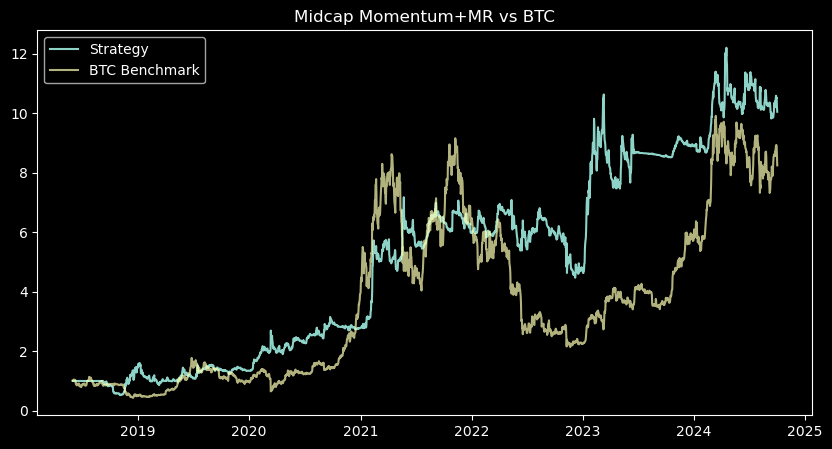

In [ ]:
# Signal construction
def momentum_signal(rets: pd.DataFrame, short=20, long=100):
    short_ma = rets.ewm(span=short, min_periods=short, adjust=False).mean()
    long_ma  = rets.ewm(span=long,  min_periods=long,  adjust=False).mean()
    vol      = rets.rolling(long, min_periods=long).std()
    z = (short_ma - long_ma) / vol
    z = np.tanh(z)
    z = z.div(z.abs().sum(axis=1), axis=0)   # normalize L1 = 1
    return z

def mean_reversion_signal(rets: pd.DataFrame, window=10):
    demean = rets.rolling(window, min_periods=window).mean()
    x = rets - demean
    cs_std = x.apply(lambda r: r.std(ddof=0), axis=1)
    z = x.div(cs_std, axis=0)
    z = -np.tanh(z)   # negative = revert
    z = z.div(z.abs().sum(axis=1), axis=0)
    return z

def risk_parity_scaler(rets: pd.DataFrame, vol_window=60, floor=1e-6):
    #Inverse-vol scaling for risk parity across assets.
    vol = rets.rolling(vol_window, min_periods=vol_window).std().clip(lower=floor)
    inv_vol = 1.0 / vol
    scaler = inv_vol.div(inv_vol.mean(axis=1), axis=0)  # normalize per date
    return scaler

def blend_signals(mom, mr, gamma=0.65):
    #Blend momentum & mean reversion signals.
    s = gamma * mom + (1 - gamma) * mr
    s = s.div(s.abs().sum(axis=1), axis=0)
    return s

# Backtesting
def backtest_midcap_mom_mr(asset_rets: pd.DataFrame,
                           btc_ret: pd.Series,
                           mom_short=20, mom_long=100,
                           mr_window=10, vol_window=60,
                           gamma=0.65, leverage=1.0, costs_bps=5):
    # Build signals
    mom = momentum_signal(asset_rets, short=mom_short, long=mom_long)
    mr  = mean_reversion_signal(asset_rets, window=mr_window)
    sig = blend_signals(mom, mr, gamma=gamma)

    # Risk parity scaling
    scaler = risk_parity_scaler(asset_rets, vol_window=vol_window)
    weights = (sig * scaler)
    weights = leverage * weights.div(weights.abs().sum(axis=1), axis=0)

    # Trade with 1-day lag
    w_t = weights.shift(1)

    # Transaction costs from turnover
    turnover = w_t.sub(w_t.shift(1)).abs().sum(axis=1).fillna(0.0)
    cost = (costs_bps / 1e4) * turnover

    # Portfolio return
    pnl_assets = (w_t * asset_rets).sum(axis=1)
    port_ret = (pnl_assets - cost).dropna()

    # Align with BTC
    aligned = pd.concat([port_ret.rename("PORT"), btc_ret.rename("BTC")], axis=1).dropna()
    port_ret = aligned["PORT"]
    btc_ret  = aligned["BTC"]

    return port_ret, btc_ret, {"weights": weights, "turnover": turnover, "signal": sig}

# Run strategy
port_ret, btc_bh_ret, extras = backtest_midcap_mom_mr(
    asset_rets=returns[kept],  
    btc_ret=btc_returns,
    mom_short=20, mom_long=100,
    mr_window=10, vol_window=60,
    gamma=0.65, leverage=1.25,
    costs_bps=5
)

print("Strategy Performance ⬇️")
s_stats = performance_stats(port_ret); print_performance_stats(s_stats)

print("\nBTC Buy&Hold ⬇️")
b_stats = performance_stats(btc_bh_ret); print_performance_stats(b_stats)

print("\nRegression vs BTC ⬇️")
reg = regression_stats(port_ret, btc_bh_ret); print_regression_stats(reg)

# Plot
plot_equity_curve(port_ret, benchmark_ret=btc_bh_ret, title="Midcap Momentum+MR vs BTC")


### Long only Momentum Strategy
**Entry Rule** 

**#1:**  Asset must be trading above higher-timeframe EMA

For midcaps: we’ll compute daily data → resample to weekly → EMA(20 weeks) → forward-fill back to daily.

**#2:**  Asset must not be in “caution” condition.

“Caution” = If recent swing high − current low > 1.5 × ATR, OR && If close < daily EMA.

Trailing Stop: Stop is trailed at:

1 ATR from recent swing high, OR

20% of ATR if in caution condition.

Strategy performance:
Sharpe    1.342844
AnnRet    0.308464
Vol       0.229710
CumRet    4.986359
MaxDD    -0.221832
dtype: float64


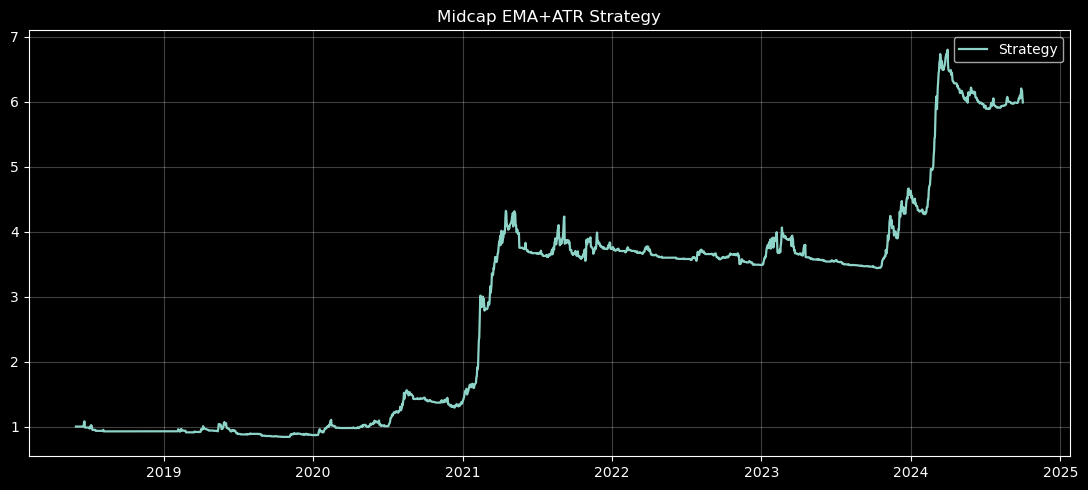

In [ ]:
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def atr(high, low, close, window=14):
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def build_strategy(prices, highs=None, lows=None, atr_window=14, weekly_span=20):

    signals = pd.DataFrame(0, index=prices.index, columns=prices.columns)

    for col in prices.columns:
        close = prices[col]
        high = highs[col] if highs is not None else close
        low  = lows[col]  if lows is not None else close

        # Rule 1
        weekly_close = close.resample("W").last()
        weekly_ema20 = ema(weekly_close, weekly_span)
        weekly_ema20 = weekly_ema20.reindex(close.index, method="ffill")
        cond1 = close > weekly_ema20

        # Rule 2
        daily_ema = ema(close, 20)
        coin_atr = atr(high, low, close, atr_window)
        swing_high = high.rolling(atr_window).max()
        swing_low  = low.rolling(atr_window).min()
        caution = ((swing_high - close) > 1.5 * coin_atr) | (close < daily_ema)
        cond2 = ~caution

        signals[col] = (cond1 & cond2).astype(int)

    return signals

signals = build_strategy(prices, highs=prices, lows=prices)

positions = signals.replace({0:0, 1:1})

# Apply to returns
rets = returns[positions.columns]  # daily returns DataFrame
strat_ret = (positions.shift(1) * rets).mean(axis=1)  # equal-weight portfolio

print("Strategy performance:")
print(performance_stats(strat_ret))
plot_equity_curve(strat_ret, benchmark_ret=None, title="Midcap EMA+ATR Strategy")

Now we allow shorts, but with stricter rules such that BTC is in a bearish regime.


Midcap EMA+ATR Asymmetric Long/Short ⬇️
Sharpe     1.3675
AnnRet     0.5575
Vol        0.4077
CumRet    19.2945
MaxDD     -0.3095
dtype: float64

BTC Buy&Hold (same dates) ⬇️
Sharpe    0.8360
AnnRet    0.5535
Vol       0.6621
CumRet    7.1237
MaxDD    -0.7663
dtype: float64


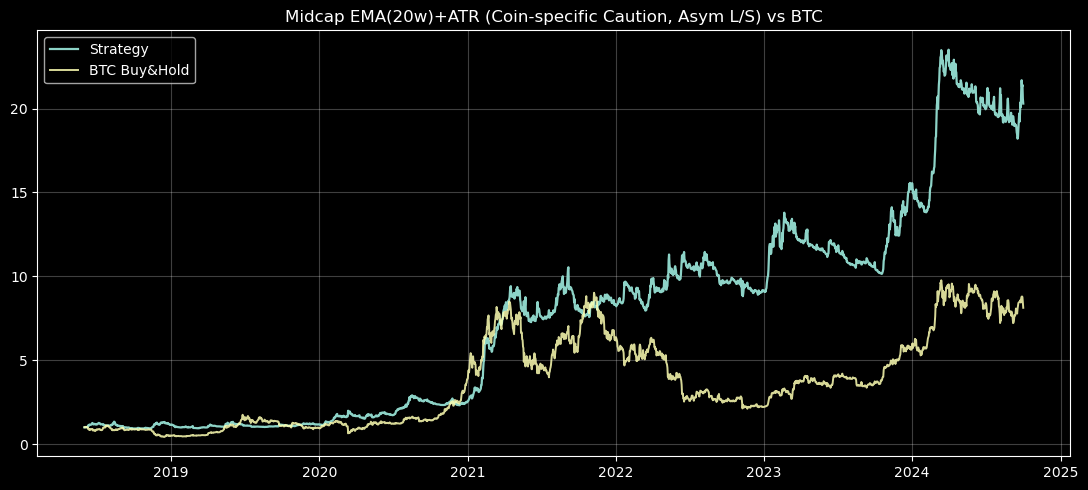

In [118]:
def build_strategy_asym(prices, btc_prices, highs=None, lows=None, atr_window=5, weekly_span=5):
    signals = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

    # BTC regime filter
    btc_weekly = btc_prices.resample("W").last()
    btc_ema20w = ema(btc_weekly, weekly_span)
    btc_ema20w = btc_ema20w.reindex(prices.index, method="ffill")
    btc_aligned = btc_prices.reindex(prices.index, method="ffill")
    btc_bear = btc_aligned < btc_ema20w

    for col in prices.columns:
        close = prices[col]
        high = highs[col] if highs is not None else close
        low  = lows[col]  if lows is not None else close

        # Rule 1: coin weekly EMA filter
        weekly_close = close.resample("W").last()
        weekly_ema20 = ema(weekly_close, weekly_span).reindex(close.index, method="ffill")

        # Rule 2: ATR
        daily_ema = ema(close, 20)
        coin_atr = atr(high, low, close, atr_window)
        swing_high = high.rolling(atr_window).max()
        swing_low  = low.rolling(atr_window).min()

        caution_long  = ((swing_high - close) > 1.5 * coin_atr) | (close < daily_ema)
        caution_short = ((close - swing_low) > 1.5 * coin_atr) | (close > daily_ema)

        # Signals
        long_sig  = (close > weekly_ema20) & (~caution_long)
        short_sig = (close < weekly_ema20) & (~caution_short) & btc_bear

        sig = pd.Series(0.0, index=close.index)
        sig[long_sig]  = 1.0  
        sig[short_sig] = -0.5

        signals[col] = sig

    return signals
signals = build_strategy_asym(prices[kept], btc_prices, highs=prices[kept], lows=prices[kept])
positions = signals.copy()
rets = returns[positions.columns]

# Equal-weight portfolio returns
port_ret = (positions.shift(1) * rets).mean(axis=1)

# Align with BTC benchmark
btc_bh = btc_returns.reindex(port_ret.index).dropna()
aligned = pd.concat([port_ret.rename("Strategy"), btc_bh.rename("BTC")], axis=1).dropna()
strat = aligned["Strategy"]; btc = aligned["BTC"]

print("Midcap EMA+ATR Asymmetric Long/Short ⬇️")
print(performance_stats(strat).round(4))
print("\nBTC Buy&Hold (same dates) ⬇️")
print(performance_stats(btc).round(4))

plot_equity_curve(strat, benchmark_ret=btc,
                  title="Midcap EMA(20w)+ATR (Coin-specific Caution, Asym L/S) vs BTC")

## Bayesian Optimization for Sharpe–MDD Tradeoff

=== Best Parameters ===
atr_window: 30
weekly_span: 18
daily_ema_span: 40
long_size: 0.6
short_size: -0.30000000000000004
use_btc_regime: False

=== Strategy Performance (Best Params) ===
Sharpe      1.6279
AnnRet      1.4221
Vol         0.8736
CumRet    761.7714
MaxDD      -0.5611
dtype: float64

=== BTC Buy&Hold (same period) ===
Sharpe    0.8393
AnnRet    0.5556
Vol       0.6620
CumRet    7.2438
MaxDD    -0.7663
dtype: float64


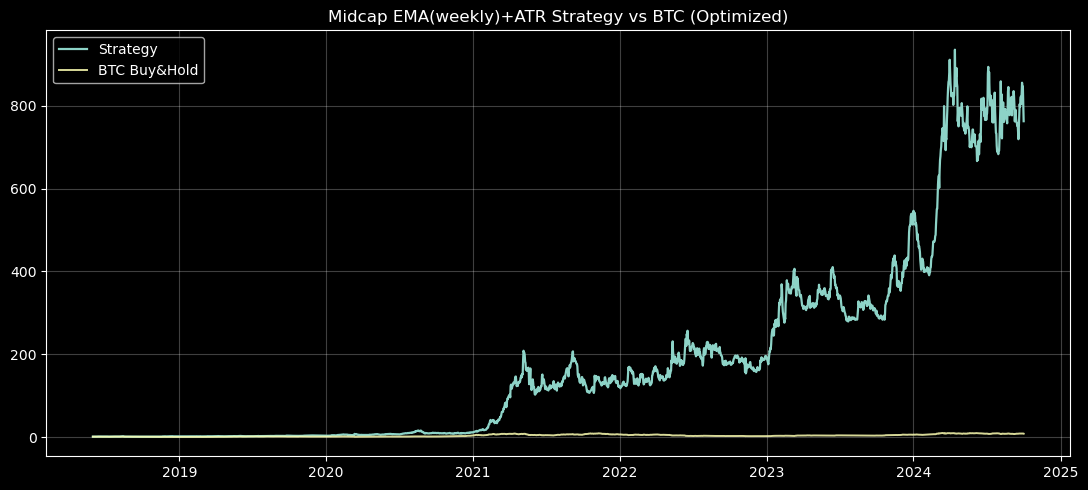

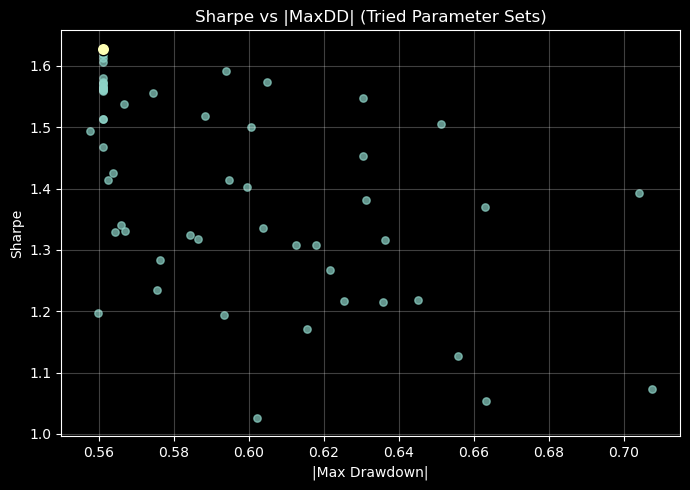

In [119]:
def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def atr(high: pd.Series, low: pd.Series, close: pd.Series, window: int = 14) -> pd.Series:
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low  - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window, min_periods=window).mean()

def performance_stats(r: pd.Series, freq: int = 365) -> pd.Series:
    r = r.dropna()
    if r.empty or r.std(ddof=0) == 0:
        return pd.Series({"Sharpe": np.nan, "AnnRet": np.nan, "Vol": np.nan, "CumRet": np.nan, "MaxDD": np.nan})
    eq = (1.0 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    return pd.Series({
        "Sharpe": r.mean() / r.std(ddof=0) * np.sqrt(freq),
        "AnnRet": r.mean() * freq,
        "Vol":    r.std(ddof=0) * np.sqrt(freq),
        "CumRet": eq.iloc[-1] - 1.0,
        "MaxDD":  dd.min()
    })

def plot_equity(strat: pd.Series, btc: pd.Series, title="Strategy vs BTC"):
    aligned = pd.concat([strat.rename("Strategy"), btc.rename("BTC")], axis=1).dropna()
    s = (1 + aligned["Strategy"]).cumprod()
    b = (1 + aligned["BTC"]).cumprod()
    plt.figure(figsize=(11,5))
    plt.plot(s, label="Strategy", linewidth=1.6)
    plt.plot(b, label="BTC Buy&Hold", alpha=0.85, linewidth=1.4)
    plt.title(title); plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout(); plt.show()

def plot_frontier(sharpes, mdds, best_idx):
    x = np.abs(np.array(mdds))  # drawdown as positive numbers
    y = np.array(sharpes)
    plt.figure(figsize=(7,5))
    plt.scatter(x, y, s=28, alpha=0.7)
    plt.scatter([x[best_idx]], [y[best_idx]], s=80, edgecolor='k', linewidths=1.0)
    plt.xlabel("|Max Drawdown|")
    plt.ylabel("Sharpe")
    plt.title("Sharpe vs |MaxDD| (Tried Parameter Sets)")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

def build_signals_coinwise(
    prices_df: pd.DataFrame,
    highs_df: pd.DataFrame = None,
    lows_df: pd.DataFrame  = None,
    atr_window: int = 14,
    weekly_span: int = 20,
    daily_ema_span: int = 20,
    long_size: float = 1.0,
    short_size: float = -1.0,
    use_btc_regime: bool = False,
    btc_prices: pd.Series = None
) -> pd.DataFrame:
    prices_df = prices_df.copy()
    if highs_df is None: highs_df = prices_df
    if lows_df  is None: lows_df  = prices_df

    # BTC bear regime
    if use_btc_regime:
        if btc_prices is None:
            raise ValueError("btc_prices must be provided if use_btc_regime=True")
        btc_weekly = btc_prices.resample("W").last()
        btc_ema_w  = ema(btc_weekly, weekly_span).reindex(prices_df.index, method="ffill")
        btc_aln    = btc_prices.reindex(prices_df.index, method="ffill")
        btc_bear   = btc_aln < btc_ema_w
    else:
        btc_bear = pd.Series(True, index=prices_df.index)

    signals = pd.DataFrame(0.0, index=prices_df.index, columns=prices_df.columns)

    for col in prices_df.columns:
        close = prices_df[col]
        high  = highs_df[col]
        low   = lows_df[col]

        # Weekly EMA per coin (map back to daily)
        weekly_close = close.resample("W").last()
        weekly_ema   = ema(weekly_close, weekly_span).reindex(close.index, method="ffill")

        # Coin-specific caution
        d_ema   = ema(close, daily_ema_span)
        coinatr = atr(high, low, close, atr_window)
        swing_h = high.rolling(atr_window, min_periods=atr_window).max()
        swing_l = low .rolling(atr_window, min_periods=atr_window).min()

        caution_long  = ((swing_h - close) > 1.5 * coinatr) | (close < d_ema)
        caution_short = ((close - swing_l) > 1.5 * coinatr) | (close > d_ema)

        long_sig  = (close > weekly_ema) & (~caution_long)
        short_sig = (close < weekly_ema) & (~caution_short) & btc_bear.reindex(close.index, method="ffill")

        sig = pd.Series(0.0, index=close.index)
        sig[long_sig]  = long_size
        sig[short_sig] = short_size
        signals[col] = sig

    return signals

def portfolio_returns_from_signals(
    signals: pd.DataFrame,
    ret_df: pd.DataFrame,
    costs_bps: float = 5.0
) -> pd.Series:
    rets = ret_df[signals.columns]
    w    = signals.copy()
    gross = w.abs().sum(axis=1).replace(0, np.nan)
    w = w.div(gross, axis=0).fillna(0.0)
    w_exec = w.shift(1)

    turnover = w_exec.sub(w_exec.shift(1)).abs().sum(axis=1).fillna(0.0)
    costs = (costs_bps / 1e4) * turnover

    port_ret = (w_exec * rets).sum(axis=1) - costs
    return port_ret.dropna()

def optimize_params(
    prices_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    kept_cols: list,
    btc_prices: pd.Series,
    btc_returns: pd.Series,
    use_btc_regime: bool = False,
    n_calls: int = 50,
    penalty_dd: float = 0.5,
    costs_bps: float = 5.0,
    random_state: int = 42
):
    space = [
        Integer(5, 30,  name="atr_window"),
        Integer(5, 30,  name="weekly_span"),
        Integer(10, 40, name="daily_ema_span"),
        Real(0.6, 1.4,  name="long_size"),
        Real(-1.0, -0.3, name="short_size"),
    ]

    tried_sharpes, tried_mdds = [], []
    tried_params = []

    def objective(params):
        atr_w, w_span, d_span, long_sz, short_sz = params
        sigs = build_signals_coinwise(
            prices_df[kept_cols], highs_df=prices_df[kept_cols], lows_df=prices_df[kept_cols],
            atr_window=atr_w, weekly_span=w_span, daily_ema_span=d_span,
            long_size=float(long_sz), short_size=float(short_sz),
            use_btc_regime=use_btc_regime, btc_prices=btc_prices
        )
        port = portfolio_returns_from_signals(sigs, returns_df[kept_cols], costs_bps=costs_bps)
        stats = performance_stats(port)
        sharpe = float(stats["Sharpe"]) if pd.notna(stats["Sharpe"]) else -1e6
        mdd    = float(stats["MaxDD"])  if pd.notna(stats["MaxDD"])  else -1.0

        tried_sharpes.append(sharpe)
        tried_mdds.append(mdd)
        tried_params.append(params)

        score = sharpe - penalty_dd * abs(mdd)  # tradeoff objective
        return -score

    res = gp_minimize(objective, space, n_calls=n_calls, random_state=random_state)
    best_idx = int(np.argmin(res.func_vals))
    best_params = res.x
    return {
        "result": res,
        "best_params": {
            "atr_window": best_params[0],
            "weekly_span": best_params[1],
            "daily_ema_span": best_params[2],
            "long_size": best_params[3],
            "short_size": best_params[4],
            "use_btc_regime": use_btc_regime
        },
        "history": {
            "sharpes": tried_sharpes,
            "mdds": tried_mdds,
            "params": tried_params,
            "best_idx": best_idx
        }
    }

assert 'prices' in globals() and 'returns' in globals() and 'kept' in globals(), "Need prices / returns / kept"
assert 'btc_prices' in globals() and 'btc_returns' in globals(), "Need btc_prices / btc_returns"

USE_BTC_REGIME = False
N_CALLS        = 60
PENALTY_DD     = 0.55
COSTS_BPS      = 5.0

opt = optimize_params(
    prices_df=prices, returns_df=returns, kept_cols=kept,
    btc_prices=btc_prices, btc_returns=btc_returns,
    use_btc_regime=USE_BTC_REGIME, n_calls=N_CALLS,
    penalty_dd=PENALTY_DD, costs_bps=COSTS_BPS, random_state=42
)

best = opt["best_params"]
print("=== Best Parameters ===")
for k,v in best.items():
    print(f"{k}: {v}")

# Re-run strategy with best params
signals_best = build_signals_coinwise(
    prices[kept], highs_df=prices[kept], lows_df=prices[kept],
    atr_window=best["atr_window"], weekly_span=best["weekly_span"], daily_ema_span=best["daily_ema_span"],
    long_size=best["long_size"], short_size=best["short_size"],
    use_btc_regime=best["use_btc_regime"], btc_prices=btc_prices
)
strat_ret = portfolio_returns_from_signals(signals_best, returns[kept], costs_bps=COSTS_BPS)

btc_bh = btc_returns.reindex(strat_ret.index).dropna()
aligned = pd.concat([strat_ret.rename("Strategy"), btc_bh.rename("BTC")], axis=1).dropna()
strat = aligned["Strategy"]; btc = aligned["BTC"]

print("\n=== Strategy Performance (Best Params) ===")
print(performance_stats(strat).round(4))
print("\n=== BTC Buy&Hold (same period) ===")
print(performance_stats(btc).round(4))

plot_equity(strat, btc, title="Midcap EMA(weekly)+ATR Strategy vs BTC (Optimized)")
plot_frontier(opt["history"]["sharpes"], opt["history"]["mdds"], opt["history"]["best_idx"])
